### Import Packages

In [1]:
# geospatial analysis
import geopandas as gpd
import shapely

# working with files
import os

# data analysis
import pandas as pd
import numpy as np

# web scraping
import requests
from bs4 import BeautifulSoup
import time
import re

# import helpful functions
from plotting_utils import *

### Essential Variables

In [2]:
# let's try to convert everything to EPSG:5070. For more accurate area measurements

# boundary for state of California
us_states = gpd.read_file("Data/Boundaries/cb_2018_us_state_500k/cb_2018_us_state_500k.shp")
us_states.to_crs("EPSG:5070", inplace=True)
ca_state = us_states[us_states["STUSPS"] == "CA"]

# California counties
us_counties = gpd.read_file("Data/Boundaries/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")
ca_counties = us_counties[us_counties["STATEFP"] == "06"]

# HUC8 subbasins (and price data)
# huc8_ca = gpd.read_file("Data/Boundaries/ca_HUC8.geojson")
huc8_ca_prices = gpd.read_file("Data/Prices/huc8_prices.geojson")

In [3]:
# input data (should we make this a JSON or yaml file later?). Note we ONLY look at operational costs

data_center_cost = 12e6 # ($/MW of capacity)

### Read in Data

Prices we already imported in the essential variables section.

Emissions and Water Scarcity

In [11]:
# # let's go with Siddik et al. data (2021) for now.
# water_carbon = pd.read_excel("Data/Footprint/Siddik/SI_XLS/Results.xlsx", sheet_name="Table 3", skiprows=1)

# # filter to only HUC rows
# water_carbon = water_carbon[~water_carbon['WSF_1MW_DC'].isna()]

# # turn HUC8 into string format
# water_carbon['HUC8_str'] = water_carbon['HUC8'].map(lambda x: ''.join(['0']*(8-len(str(x)))) + str(x))

# # merge with California data
# huc8_ca = huc8_ca.merge(water_carbon, how="inner", left_on="HUC8", right_on="HUC8_str")

# read in the derived values
footprint_df = pd.read_csv("Data/Footprint/footprint_per_MW.csv", index_col=0)
footprint_df['HUC8_str'] = footprint_df['HUC8'].map(lambda x: ''.join(['0']*(8-len(str(x)))) + str(x))



All of the HUC8 Data Together

In [ ]:
huc8_df = huc8_ca_prices.merge(footprint_df, left_on='HUC8', right_on='HUC8_str')

Compute the normalization factors: standard deviation

In [ ]:
S_std = huc8_df['Grid WSF_1MWh'].std() # water scarcity footprint
P_std = huc8_df['Electricity Price ($/MWh)'].std() # price
E_std = huc8_df['Grid CF_1MWh'].std() # emissions

Normalize the Data (so we don't have to worry about this later on)

In [ ]:
huc8_weights_default = huc8_df.copy()

# normalize the grid metrics
huc8_df['Grid WSF_1MWh_normalized'] = huc8_df['Grid WSF_1MWh']/S_std
huc8_df['Electricity Price_normalized'] = huc8_df['Electricity Price ($/MWh)']/P_std
huc8_df['Grid CF_1MWh_normalized'] = huc8_df['Grid CF_1MWh']/E_std

# normalize the solar metrics
huc8_df['Solar WSF_1MWh_normalized'] = huc8_df['Solar WSF_1MWh']/S_std
huc8_df['Mean Solar LCOE_normalized'] = huc8_df['Mean Solar LCOE ($/MWh)']/P_std
huc8_df['Solar CF_1MWh_normalized'] = huc8_df['Solar CF_1MWh']/E_std

# normalize the wind metrics
huc8_df['Wind WSF_1MWh_normalized'] = huc8_df['Wind WSF_1MWh']/S_std
huc8_df['Mean Wind LCOE_normalized'] = huc8_df['Mean Wind LCOE ($/MWh)']/P_std
huc8_df['Wind CF_1MWh_normalized'] = huc8_df['Wind CF_1MWh']/E_std


# normalize the data center metrics
huc8_df['Data Center WSF_1MWh_normalized'] = huc8_df['Data Center WSF_1MWh']/S_std
data_center_cost_normalized = data_center_cost/P_std

Solar and Wind Production Proportions

In [4]:
# solar production proportion
solar_proportion_df = pd.read_csv("Data/Solar/solar_proportion_2013_huc8.csv", index_col=0)

# wind production proportion
wind_proportion_df = pd.read_csv("Data/Wind/wind_proportion_2013_huc8.csv", index_col=0)

Demand Profiles

In [61]:
# import only the 2GWh cases, because we only need the 2GWh cases.
flat_demand_2GWh = pd.read_csv("Data/Demand Profiles/flat_2_GWh.csv", index_col=0)

business_demand_2GWh = pd.read_csv("Data/Demand Profiles/business_2GWh.csv", index_col=0)

caiso_2013_2GWh = pd.read_csv("Data/Demand Profiles/caiso_2013_2GWh.csv", index_col=0)

### Land Restrictions

In summary, we can basically ignore land property restrictions.

We haven't investigated hosting capacity yet.

In [ ]:
# let's not worry about utilities for now, just for time. and I don't think it's the most important restriction
# # utilities map in California
# ca_utilities = gpd.read_file("Data/Boundaries/ElectricLoadServingEntities_IOU_POU_-6992589901327565970.geojson")

In [ ]:
# federal, state, local lands
# not too many tribal lands in California so we don't worry about that

if False:
    # overall takes 30 seconds
    us_lands = gpd.read_file("Data/Boundaries/USA_Federal_Lands_1879006603790792540.geojson")

    # filter invalid geometries
    us_lands = us_lands[~us_lands['geometry'].isna()]
    us_lands = us_lands[us_lands['geometry'].is_valid]

    us_lands.to_crs("EPSG:5070", inplace=True)

    # first filter US lands to California
    ca_geometry = ca_state.iloc[0].geometry
    us_lands_ca = us_lands[us_lands.intersects(ca_geometry)]

In [ ]:
# cut out US lands from California subbasins

# overall, turns out that no HUC8 (besides some island) is fully contained in federal land.

if False:
    # takes around 30 seconds
    all_us_land = us_lands_ca.union_all()

    subbasin_us_land = []

    for idx, row in huc8_ca.iterrows():
        if shapely.contains(all_us_land, row['geometry']):
            print(idx)
            subbasin_us_land.append(True)
        else:
            subbasin_us_land.append(False)

    huc8_ca["Government_Land"] = subbasin_us_land
    huc8_ca = huc8_ca[~huc8_ca["Government_Land"]]

355


### Visualize Input Data

#### Time series

Text(0.5, 1.0, 'Demand Profile: Flat Demand Scenario')

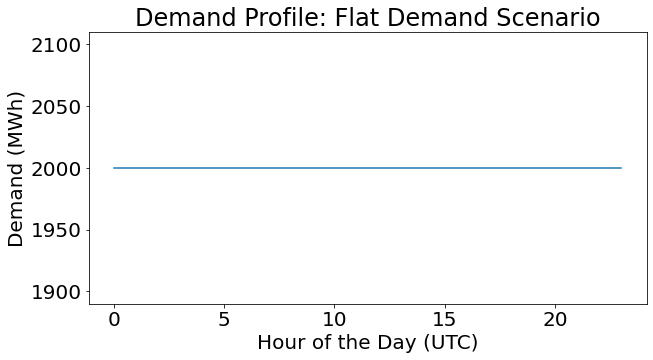

In [66]:
# flat demand curve (same every day)
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), flat_demand_2GWh['0'].to_numpy()[0:24])

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand (MWh)")
ax.set_title("Demand Profile: Flat Demand Scenario")

Text(0.5, 1.0, 'Demand Profile: Business-Heavy Scenario')

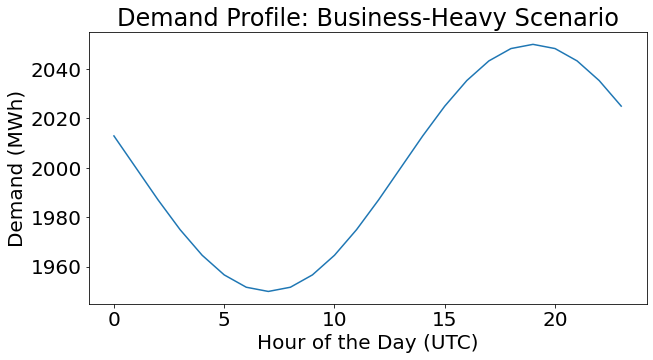

In [68]:
# business hour curve, inspired by https://www.ethree.com/wp-content/uploads/2024/07/E3-White-Paper-2024-Load-Growth-Is-Here-to-Stay-but-Are-Data-Centers-2.pdf page 14
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), business_demand_2GWh['0'].to_numpy()[0:24])

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand (MWh)")
ax.set_title("Demand Profile: Business-Heavy Scenario")

In [76]:
# CAISO curve
caiso_2013_2GWh_np = caiso_2013_2GWh['0'].to_numpy().reshape((-1,24)) # reshape to 365 * 24

# compute mean and standard deviation
caiso_2013_mean = np.mean(caiso_2013_2GWh_np, axis=0)

caiso_2013_std = np.std(caiso_2013_2GWh_np, axis=0)


Text(0.5, 1.0, 'Demand Profile: CAISO Scenario')

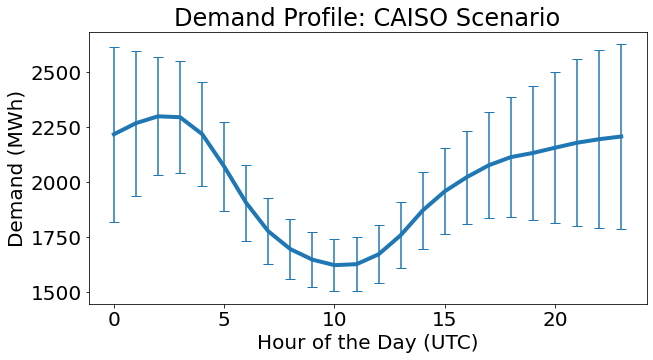

In [92]:
# plot CAISO curve
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(np.arange(24), caiso_2013_mean, linewidth=4)
ax.errorbar(np.arange(24), caiso_2013_mean, yerr=caiso_2013_std, capsize=5, fmt='None')

ax.set_xlabel("Hour of the Day (UTC)")
ax.set_ylabel("Demand (MWh)")
ax.set_title("Demand Profile: CAISO Scenario")

#### Maps

<Axes: title={'center': 'Electricity Rate \nin HUC8 Subbasins'}>

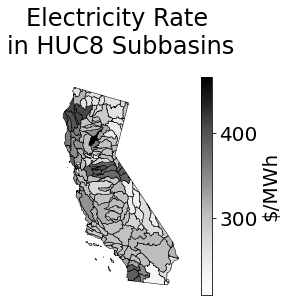

In [ ]:
# grid electricity prices
visualize_stats(huc8_df, 'Electricity Price ($/MWh)', 'Electricity Rate', 'Grays', '$/MWh')

<Axes: title={'center': 'Solar LCOE'}>

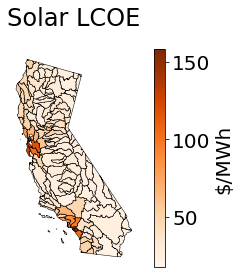

In [ ]:
# solar electricity prices
visualize_stats(huc8_df, 'Mean Solar LCOE ($/MWh)', 'Solar LCOE', 'Oranges', '$/MWh')

<Axes: title={'center': 'Wind LCOE'}>

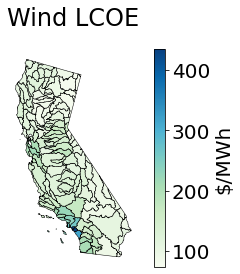

In [ ]:
# wind electricity prices
visualize_stats(huc8_df, 'Mean Wind LCOE ($/MWh)', 'Wind LCOE', 'GnBu', '$/MWh')

<Axes: title={'center': 'Characterization factor'}>

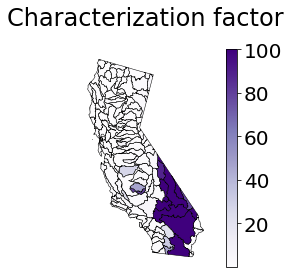

In [ ]:
# chracterization factor (ratio of water stress footprint/water footprint)
visualize_stats(huc8_df, 'Characterization factor', 'Characterization factor', 'Purples', '') # a unitless measure.

<Axes: title={'center': 'Water Scarcity Footprint \nfor Grid Electricity'}>

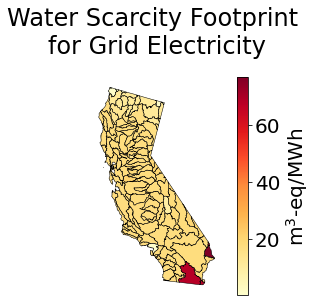

In [ ]:
# water scarcity footprint: grid
visualize_stats(huc8_df, 'Grid WSF_1MWh', 'Water Scarcity Footprint \nfor Grid Electricity', 'YlOrRd', r'm$^3$-eq/MWh')

<Axes: title={'center': 'Water Scarcity Footprint \nfor Data Centers'}>

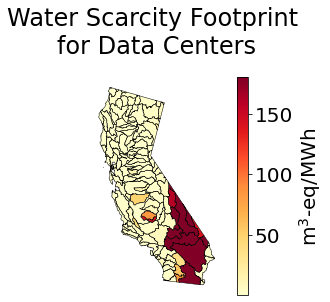

In [ ]:
# water scarcity footprint: data center
visualize_stats(huc8_df, 'Data Center WSF_1MWh', 'Water Scarcity Footprint \nfor Data Centers', 'YlOrRd', r'm$^3$-eq/MWh')

<Axes: title={'center': 'Emissions Footprint \nof Grid Electricity'}>

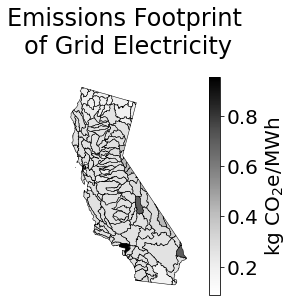

In [ ]:
# emissions footprint: grid
visualize_stats(huc8_df, 'Grid CF_1MWh', 'Emissions Footprint \nof Grid Electricity', 'Greys', r'kg CO$_{2}$e/MWh')

### Model Implementation

Model-Specific Data: Derived Costs

Visualize Composite Costs: Grid, Solar, and Wind

In [ ]:
# functionalize

grid_parts_list = ['Grid WSF_1MWh_normalized', 'Electricity Price_normalized', 'Grid CF_1MWh_normalized']
solar_parts_list = ['Solar WSF_1MWh_normalized', 'Mean Solar LCOE_normalized', 'Solar CF_1MWh_normalized']
wind_parts_list = ['Wind WSF_1MWh_normalized', 'Mean Wind LCOE_normalized', 'Wind CF_1MWh_normalized']

def composite_costs(weights):
    """ 
    Calculates composite costs based on input weights.

    Parameters
    ----------
        weights: dict
            Dictionary of weights.

    Returns
    -------
        composite_costs_df: gpd.GeoDataFrame
            GeoDataframe with composite costs.
    """

    composite_costs_df = huc8_df.copy()

    # composite cost: grid electricity
    composite_costs_df['grid_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in grid_parts_list], axis=0)

    composite_costs_df['solar_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in solar_parts_list], axis=0)

    composite_costs_df['wind_composite_cost'] = np.sum([weights[part]*huc8_weights_default[part] for part in wind_parts_list], axis=0)

    return composite_costs_df

### Visualization of Results

In [ ]:
time_index = solar_proportion_df.index

def result_df(x, a, g, s, w): # consider whether we should combine this with the function above. - Richard
    """
    Stores optimized decision variables in a DataFrame for easy visualization.

    Parameters
    ----------
        x: Gurobi output
            Siting decisions of data centers
        a: Gurobi output
            Data center load allocation matrix
        g: Gurobi output
            Grid electricity usage matrix
        s: Gurobi output
            Annual solar usage
        w: Gurobi output
            Annual wind usage

    Returns
    -------
        huc8_decisions_df: gpd.GeoDataFrame
            GeoDataFrame with all of the decision variables
    """

    huc8_decisions_df = huc8_df.copy()

    huc8_decisions_df['Added Data Centers (MW)'] = x

    for idx, time in enumerate(time_index):
        huc8_decisions_df[f"Allocation {time}"] = a[:,idx]

        huc8_decisions_df[f"Grid {time}"] = g[:,idx]

    huc8_decisions_df[f"Total Allocation (MWh)"] = np.sum(a, axis=1)

    huc8_decisions_df[f"Total Grid Usage (MWh)"] = np.sum(g, axis=1)

    huc8_decisions_df['Annual Solar Usage (MWh)'] = s

    huc8_decisions_df['Annual Wind Usage (MWh)'] = w

    # get data center usage rates
    huc8_decisions_df['Divide Data Centers'] = huc8_decisions_df['Added Data Centers (MW)'].where(huc8_decisions_df['Added Data Centers (MW)'] > 0, 1)

    huc8_decisions_df['Data Center Capacity Factor'] = huc8_decisions_df['Total Allocation (MWh)']/(huc8_decisions_df['Divide Data Centers']*8760)

    return huc8_decisions_df

In [ ]:
# added data centers
visualize_stats(huc8_decisions_df, 'Added Data Centers (MW)', 'Added Data Center Capacity', 'Greens', 'MW')

In [ ]:
# data center capacity factor
visualize_stats(huc8_decisions_df, 'Data Center Capacity Factor', 'Data Center Capacity Factor', 'Greys', '') # unitless. We can also change to percentage if we want.

In [ ]:
# pie chart: size is the total electricity consumption. sectors are how much electricity consumption comes from grid, solar, wind.

huc8_decisions_df['Total Grid Usage (MWh)']
huc8_decisions_df['Annual Solar Usage (MWh)']
huc8_decisions_df['Annual Wind Usage (MWh)']

In [ ]:
# pie chart: size is the total water scarcity footprint. sectors are how much water scarcity footprint comes from grid, solar, wind, data center.

huc8_decisions_df['Total Grid WSF (m^3-eq)'] = huc8_decisions_df['Total Grid Usage (MWh)'] * huc8_decisions_df['Grid WSF_1MWh']
huc8_decisions_df['Total Solar WSF (m^3-eq)'] = huc8_decisions_df['Annual Solar Usage (MWh)'] * huc8_decisions_df['Solar WSF_1MWh']
huc8_decisions_df['Total Wind WSF (m^3-eq)'] = huc8_decisions_df['Annual Wind Usage (MWh)'] * huc8_decisions_df['Wind WSF_1MWh']
huc8_decisions_df['Total Data Center WSF (m^3-eq)'] = huc8_decisions_df['Total Allocation (MWh)'] * huc8_decisions_df['Data Center WSF_1MWh']

In [ ]:
# pie chart: size is the total emissions footprint. sectors are how much emissions footprint comes from grid, solar, and wind

huc8_decisions_df['Total Grid Emissions'] = huc8_decisions_df['Total Grid Usage (MWh)'] * huc8_decisions_df['Grid CF_1MWh']
huc8_decisions_df['Total Solar Emissions'] = huc8_decisions_df['Annual Solar Usage (MWh)'] * huc8_decisions_df['Solar CF_1MWh']
huc8_decisions_df['Total Wind Emissions'] = huc8_decisions_df['Annual Wind Usage (MWh)'] * huc8_decisions_df['Wind CF_1MWh']

In [ ]:
# pie chart: size is the total cost. sectors are how much cost comes from grid, solar, wind, and data center

huc8_decisions_df['Total Grid Cost'] = huc8_decisions_df['Total Grid Usage (MWh)'] * huc8_decisions_df['Electricity Price ($/MWh)']
huc8_decisions_df['Total Solar Cost'] = huc8_decisions_df['Annual Solar Usage (MWh)'] * huc8_decisions_df['Mean Solar LCOE ($/MWh)']
huc8_decisions_df['Total Wind Cost'] = huc8_decisions_df['Annual Wind Usage (MWh)'] * huc8_decisions_df['Mean Wind LCOE ($/MWh)']
huc8_decisions_df['Total Data Center Cost'] = huc8_decisions_df['Added Data Centers (MW)'] * data_center_cost

In [ ]:
# pick colors

color_dict = {
    'grid': 'silver',
    'solar': 'yellow',
    'wind': 'blue',
    'data center': 'red'
}

In [ ]:
# if this gets too complicated, place it into a class structure.
def geoplot_pie(df, lat_col, lon_col, category_dict, unit_factor, unit, pie_scale, ax=None):
    """ 
    Plot a map, with pie charts at the centroid of each region. Area of pie chart is proportional to the total amount.

    Parameters
    ----------
        df: gpd.GeoDataFrame
            GeoDataFrame with data of interest.
        lat_col: string
            Name of column with latitude coordinates.
        lon_col: string
            Name of column with longitude coordinates.
        category_dict: dictionary
            Dictionary with sources (grid, solar, wind, data center) as keys, and column names as values.
        unit_factor: float
            Conversion factor from measurements to unit of measurement.
        unit: string
            Unit of measurement.
        pie_scale: float
            Scaling factor for pie size.
        ax: matplotlib.axes.Axes
            Axes to plot the map and pie chart on.

    Returns
    -------
        None
    """

    if ax is None:
        ax = plt.gca() # get current axis
    

    # plot the pie charts
    for _, row in df.iterrows():
        lat, lon = transformer_inv.transform(row[lat_col], row[lon_col])
        ax.pie(row[category_dict.values()], labels=category_dict.keys(), radius=np.sqrt(row[category_dict.values()].sum()) * pie_scale, \
               center=(lon, lat), colors=color_dict[category_dict.keys()])
        
    # make the pie size legend
    ref_sizes = np.linspace(0, df[category_dict.values()].sum().max(), 4)[1:] # get three reference sizes

    for size in ref_sizes:
        ref_label = f'{size * unit_factor:.1f}' + unit
        ax.pie(size, radius=size * pie_scale, color='white', zorder=-3, label=ref_label) # TODO might need to modify this later on

    # make the color legend
    for key in category_dict.keys():
        ax.bar(0, 0, color=color_dict[key], label=key, zorder=-3)

    ax.legend()